## CNN LSTM in text classification context,  implemented in keras

In the following, different neural network architectures ( cnn, lstm, rnn) are introduced within the context of text classification. 

We are trying to classify the dataset of extemely polar sentiment reviews into two classes ( positive and negative) 

If you are not comfortable with the pre-processing of the text, please skim through it and focus more on the architectures part, which was explained in the later part of the tutorial.

Dowload the dataset [Sentiment labelled sentences data set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) from UCI archive

Import the dataset 

In [1]:
import pandas as pd


filepath_dict = {'yelp':   '../data/sentiment_analysis/yelp_labelled.txt',
                 'amazon': '../data/sentiment_analysis/amazon_cells_labelled.txt',
                 'imdb':   '../data/sentiment_analysis/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


 [ref1](https://realpython.com/python-keras-text-classification/)

## Defining a Baseline Model
When you work with machine learning, one important step is to define a baseline model. This usually involves a simple model, which is then used as a comparison with the more advanced models that you want to test. In this case, you’ll use the baseline model to compare it to the more advanced methods involving (deep) neural networks, the meat and potatoes of this tutorial.

First, you are going to split the data into a training and testing set which will allow you to evaluate the accuracy and see if your model generalizes well. This means whether the model is able to perform well on data it has not seen before. This is a way to see if the model is overfitting.
Overfitting is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data. 

We start by taking the Yelp data set which we extract from our concatenated data set. From there, we take the sentences and labels. The .values returns a NumPy array instead of a Pandas Series object which is in this context easier to work with:

In [2]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

You can use again the CountVectorizer for this task. Since you might not have the testing data available during training, you can create the vocabulary using only the training data. Using this vocabulary, you can create the feature vectors for each sentence of the training and testing set:

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 1714 dimensions which is the size of the vocabulary. Also, you can see that we get a sparse matrix. This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

CountVectorizer performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

*Note: There are a lot of additional parameters to CountVectorizer() that we forgo using here, such as adding ngrams, beacuse the goal at first is to build a simple baseline model . The token pattern itself defaults to token\_pattern =’(?u)\b\w\w+\b’, which is a regex pattern that says, “a word is 2 or more Unicode word characters surrounded by word boundaries.”.*

The classification model we are going to use is the logistic regression which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (by default 0.5), the regression model is used for classification. You can use again scikit-learn library which provides the LogisticRegression classifier:

In [4]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score) #Accuracy: 0.796

Accuracy: 0.796


You can see that the logistic regression reached an impressive 79.6%, but let’s have a look how this model performs on the other data sets that we have. In this script, we perform and evaluate the whole process for each data set that we have:

In [5]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))
    # Accuracy for yelp data: 0.7960
    #Accuracy for amazon data: 0.7960
    #Accuracy for imdb data: 0.7487

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Your first kera model

Keras supports two main types of models. You have the [Sequential model API](https://keras.io/models/sequential/) which you are going to see in use in this tutorial and the [functional API](https://keras.io/models/model/) which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the [Dense layer](https://keras.io/layers/core/#dense) which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

Let’s see if we can achieve some improvement to our previous logistic regression model. You can use the X_train and X_test arrays that you built in our earlier example.

Before we build our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. In order to build the Sequential model, you can add layers one by one in order as follows:

In [6]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#Using TensorFlow backend.

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Before you can start with the training of the model, you need to configure the learning process. This is done with the .compile() method. This method specifies the optimizer and the loss function.

Additionally, you can add a list of metrics which can be later used for evaluation, but they do not influence the training. In this case, we want to use the binary cross entropy and the Adam optimizer you saw in the primer mentioned before. Keras also includes a handy .summary() function to give an overview of the model and the number of parameters available for training:

In [7]:
model.compile(loss='binary_crossentropy',
               optimizer='adam', 
                 metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


You might notice that we have 8575 parameters for the first layer and another 6 in the next one. Where did those come from?
See, we have 1714 dimensions for each feature vector, and then we have 5 nodes. We need weights for each feature dimension and each node which accounts for 1714 * 5 = 8570 parameters, and then we have another 5 times an added bias for each node, which gets us the 8575 parameters. In the final node, we have another 5 weights and one bias, which gets us to 6 parameters.

Now it is time to start your training with the .fit() function.

Since the training in neural networks is an iterative process, the training won’t just stop after it is done. You have to specify the number of iterations you want the model to be training. Those completed iterations are commonly called __epochs__. We want to run it for 100 epochs to be able to see how the training loss and accuracy are changing after each epoch.

Another parameter you have to your selection is the __batch size__. The batch size is responsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass. This increases the speed of the computation as it need fewer epochs to run, but it also needs more memory, and the model may degrade with larger batch sizes. Since we have a small training set, we can leave this to a low batch size:

In [8]:
 history = model.fit(X_train, y_train,
                     epochs=100,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=10,
                    )

Now you can use the .evaluate() method to measure the accuracy of the model. You can do this both for the training data and testing data. We expect that the training data has a higher accuracy then for the testing data. Tee longer you would train a neural network, the more likely it is that it starts overfitting.

*Note that if you rerun the .fit() method, you’ll start off with the computed weights from the previous training.*

Make sure to compile the model again before you start training the model again. Now let’s evaluate the accuracy model:

In [9]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7861


You can already see that the model was overfitting since it reached 100% accuracy for the training set. But this was expected since the number of epochs was fairly large for this model. However, the accuracy of the testing set has already surpassed our previous logistic Regression with BOW model, which is a great step further in terms of our progress.

To make your life easier, you can use this little helper function to visualize the loss and accuracy for the training and testing data based on the [History](https://keras.io/callbacks/#history) callback. This callback, which is automatically applied to each Keras model, records the loss and additional [metrics](https://keras.io/metrics/) that can be added in the .fit() method. In this case, we are only interested in the accuracy. This helper function employs the [matplotlib](https://matplotlib.org/) plotting library:

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

To use this function, simply call plot_history() with the collected accuracy and loss inside the history dictionary:

In [11]:
plt.show()
plot_history(history)
plt.close()

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epochs in this training.

*Note: When training neural networks, you should use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.
This makes sure that you don’t overfit the model. Using the validation set to choose the best model is a form of data leakage (or “cheating”) to get to pick the result that produced the best test score out of hundreds of them. Data leakage happens when information outside the training data set is used in the model.*

In this case, our testing and validation set are the same, since we have a smaller sample size. As we have covered before, (deep) neural networks perform best when you have a very large number of samples. In the next part, you’ll see a different way to represent words as vectors. This is a very exciting and powerful way to work with words where you’ll see how to represent words as dense vectors.

##  Neural Networks

There are two options to get word-embeddings. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also. 

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for [text preprocessing](https://keras.io/preprocessing/text/) and [sequence preprocessing](https://keras.io/preprocessing/sequence/) which you can employ to prepare your text.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter **num_words**, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kept. I have the testing and training data prepared from the previous example:

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which I’ll introduce in a moment.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the word_index dictionary of the Tokenizer object:

In [13]:
for word in ['the', 'all','good']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
good: 33


**Note**: *Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.
With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index. *

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.
Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [14]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


The first values represent the index in the vocabulary as you have learned from the previous examples. You can also see that the resulting feature vector contains mostly zeros, since you have a fairly short sentence. In the next part you will see how to work with word embeddings in Keras.

## Keras Embedding Layer
Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:
1. input_dim: the size of the vocabulary
2. output_dim: the size of the dense vector
3. input_length: the length of the sequence 

With the [Embedding layer](https://keras.io/layers/embeddings/) we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

In [15]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 87350 new parameters to train. This number comes from vocab_size times the embedding_dim. These weights of the embedding layer are initialized with random weights and are then adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors. You can train it with the following:

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.6578


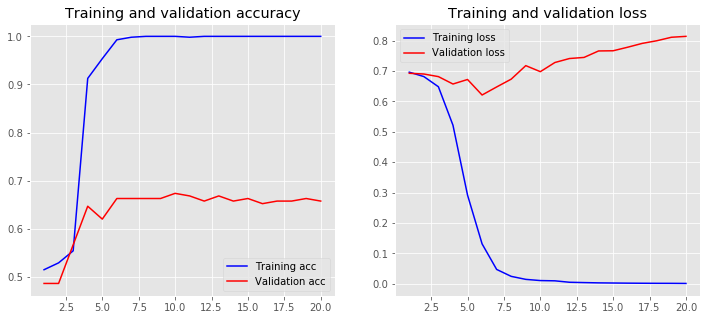

In [16]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   )
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)
plt.show()
plt.close()

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information. 

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to [downsample](https://en.wikipedia.org/wiki/Decimation_(signal_processing)) (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.
Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [17]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


the procedure for training doesnt change

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7647


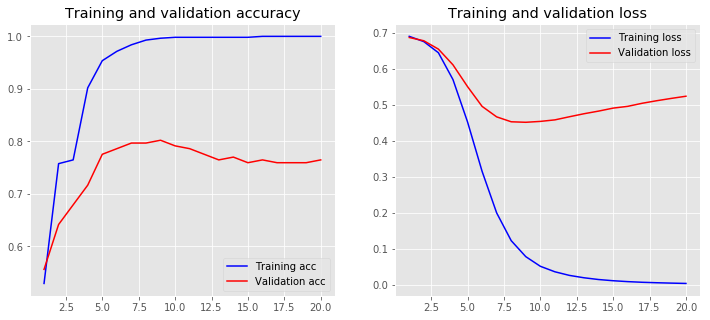

In [18]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   )
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
plt.show()

plt.close()

## Using Pretrained Word Embeddings
We just saw an example of jointly learning word embeddings incorporated into the larger model that we want to solve.
An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) developed by Google and [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) developed by the Stanford NLP Group.

Note that those are different approaches with the same goal. Word2Vec achieves this by employing neural networks and GloVe achieves this with a co-occurrence matrix and by using matrix factorization. In both cases you are dealing with dimensionality reduction, but Word2Vec is more accurate and GloVe is faster to compute.

Below you’ll see how to work with the GloVe word embeddings from the Stanford NLP Group as their size is more manageable than the Word2Vec word embeddings provided by Google. Go ahead and download the 6B (trained on 6 billion words) word embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB).

You can find other word embeddings also on the main [GloVe](https://nlp.stanford.edu/projects/glove/) page. You can find the pretrained Word2Vec embeddings by Google [here](https://code.google.com/archive/p/word2vec/). If you want to train your own word embeddings, you can do so efficiently with the [gensim](https://radimrehurek.com/gensim/index.html) Python package which uses Word2Vec for calculation. More details on how to do this [here](https://radimrehurek.com/gensim/models/word2vec.html).

Now that we got you covered, you can start using the word embeddings in your models. You can see in the next example how you can load the embedding matrix. Each line in the file starts with the word and is followed by the embedding vector for the particular word.

This is a large file with 400000 lines, with each line representing a word followed by its vector as a stream of floats. For example, here are the first 50 characters of the first line:

In [19]:
"""
head -n 1 data/glove_word_embeddings/glove.6B.50d.txt | cut -c-50
"""

'\nhead -n 1 data/glove_word_embeddings/glove.6B.50d.txt | cut -c-50\n'

Since you don’t need all words, you can focus on only the words that we have in our vocabulary. Since we have only a limited number of words in our vocabulary, we can skip most of the 40000 words in the pretrained word embeddings:

In [20]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [21]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('../data/glove_word_embeddings/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

Now you are ready to use the embedding matrix in training. Let’s go ahead and use the previous network with global max pooling and see if we can improve this model. When you use pretrained word embeddings you have the choice to either allow the embedding to be updated during training or only use the resulting embedding vectors as they are.
First, let’s have a quick look how many of the embedding vectors are nonzero:

In [22]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

This means 95.1% of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary. Let’s have a look at the performance when using the GlobalMaxPool1D layer:

In [23]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Training Accuracy: 0.7861
Testing Accuracy:  0.7701


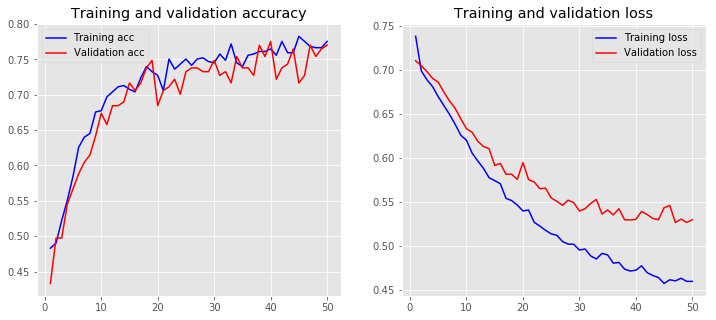

In [24]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
plt.show()
plt.close()

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using trainable=True:

In [25]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7647


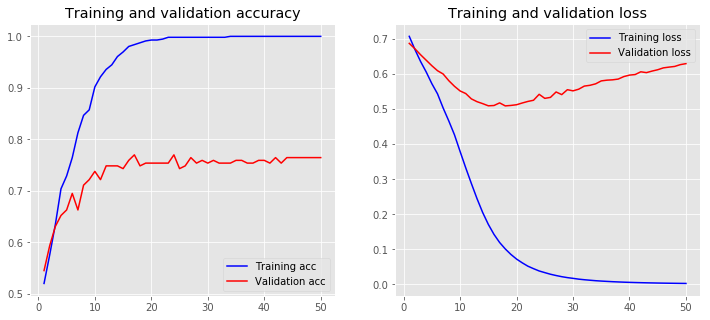

In [26]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
plt.show()
plt.close()

You can see that it is most effective to allow the embeddings to be trained. When dealing with large training sets it can boost the training process to be much faster than without. In our case it seemed to help but not by much. This does not have to be because of pretrained word embeddings.

Now it is time to focus on a more advanced neural network model to see if it is possible to boost the model and give it the leading edge over the previous models.

# CNN 

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

This is the very core of the technique, the mathematical process of [convolution](https://en.wikipedia.org/wiki/Convolution) . With each convolutional layer the network is able to detect more complex patterns. In the [Feature Visualization](https://distill.pub/2017/feature-visualization/) by Chris Olah you can get a good intuition what these features can look like.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

In the next figure you can see how such a convolution works. It starts by taking a patch of input features with the size of the filter kernel. With this patch you take the dot product of the multiplied weights of the filter. The one dimensional convnet is invariant to translations, which means that certain sequences can be recognized at a different position. This can be helpful for certain patterns in the text:



![1D convolution](../notebook_images/njanakiev-1d-convolution.d7afddde2776.png "1D convolution") [image source](https://realpython.com/asins/1617294438/)

Now let’s have a look how you can use this network in Keras. Keras offers again various [Convolutional layers](https://keras.io/layers/convolutional/) which you can use for this task. The layer you’ll need is the Conv1D layer. This layer has again various parameters to choose from. The ones you are interested in for now are the number of filters, the kernel size, and the activation function. You can add this layer in between the Embedding layer and the GlobalMaxPool1D layer

In [27]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7807


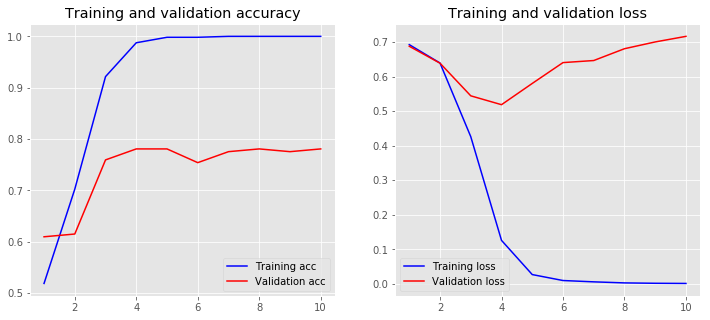

In [28]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
plt.show()
plt.close()

You can see that 80% accuracy seems to be tough hurdle to overcome with this data set and a CNN might not be well equipped. The reason for such a plateau might be that:
1. There are not enough training samples
2. The data you have does not generalize well
3. Missing focus on tweaking the hyperparameters
CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.

### Hyperparameters Optimization
One crucial steps of deep learning and working with neural networks is [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)
As you saw in the models that we have used so far, even with simpler ones, you had a large number of parameters to tweak and choose from. Those parameters are called hyperparameters. This is the most time consuming part of machine learning and sadly there are no one-fits-all solutions ready.

One popular method for hyperparameter optimization is [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search). What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, **random search**, which you’ll see in action here, simply takes random combinations of parameters.

In order to apply random search with Keras, you will need to use the [KerasClassifier](https://keras.io/scikit-learn-api/) which serves as a wrapper for the [scikit-learn API](https://keras.io/scikit-learn-api/). With this wrapper you are able to use the various tools available with scikit-learn like cross-validation. The class that you need is [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) which implements random search with [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html). Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data sets. 

There are various types of cross-validation. One type is the **k-fold cross-validation** which you’ll see in this example. In this type the data set is partitioned into _k_ equal sized sets where one set is used for testing and the rest of the partitions are used for training. This enables you to run _k_ different runs, where each partition is once used as a testing set. So, the higher _k_ is the more accurate the model evaluation is, but the smaller each testing set is.

First step for KerasClassifier is to have a function that creates a Keras model. We will use the previous model, but we will allow various parameters to be set for the hyperparameter optimization:

In [29]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Next, you want to define the parameter grid that you want to use in training. This consists of a dictionary with each parameters named as in the previous function. The number of spaces on the grid is 3 \* 3 \* 1 \* 1 \* 1, where each of those numbers is the number of different choices for a given parameter.

You can see how this could get computationally expensive very quickly, but luckily both grid search and random search are embarrassingly parallel, and the classes come with an *n_jobs* parameter that lets you test grid spaces in parallel. The parameter grid is initialized with the following dictionary:


In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

Now you are already ready to start running the random search. In this example we iterate over each data set and then you want to preprocess the data in the same way as previously. Afterwards you take the previous function and add it to the *KerasClassifier* wrapper class including the number of epochs.

The resulting instance and the parameter grid are then used as the estimator in the *RandomSearchCV class*. Additionally, you can choose the number of folds in the k-folds cross-validation, which is in this case 4. You have seen most of the code in this snippet before in our previous examples. Besides the *RandomSearchCV* and *KerasClassifier*, I have added a little block of code handling the evaluation:

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = '../data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: 

*This step is gonna take some time*

For some reason the testing accuracy is higher than the training accuracy which might be because there is a large variance in the scores during cross-validation. We can see that we were still not able to break much through the dreaded 80%, which seems to be a natural limit for this data with its given size. Remember that we have a small data set and convolutional neural networks tend to perform the best with large data sets.

Another method for CV is the **nested cross-validation** (shown [here](http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html#grid-search) which is used when the hyperparameters also need to be optimized. This is used because the resulting non-nested CV model has a bias toward the data set which can lead to an overly optimistic score. You see, when doing hyperparameter optimization as we did in the previous example, we are picking the best hyperparameters for that specific training set but this does not mean that these hyperparameters generalize the best.

# LSTM

Long Short Term Memory networks (LSTM) are a subclass of RNN, specialized in remembering information for an extended period. Moreover, the Bidirectional LSTM keeps the contextual information in both directions which is pretty useful in text classification task (But won’t work for a time series prediction task as we don’t have visibility into the future in this case).
![LSTM](../notebook_images/lstm.png "LSTM")

For a most simplistic explanation of Bidirectional RNN, think of RNN cell as a black box taking as input a hidden state(a vector) and a word vector and giving out an output vector and the next hidden state. This box has some weights which are to be tuned using Backpropagation of the losses. Also, the same cell is applied to all the words so that the weights are shared across the words in the sentence. This phenomenon is called weight-sharing.
![RNN node](../notebook_images/rnn1.png "rnn")
Hidden state, Word vector ->(RNN Cell) -> Output Vector , Next Hidden state

For a sequence of length 4 like “you will never believe”, The RNN cell gives 4 output vectors, which can be concatenated and then used as part of a dense feedforward architecture.
In the Bidirectional RNN, the only change is that we read the text in the usual fashion as well in reverse. So we stack two RNNs in parallel, and hence we get 8 output vectors to append.
Once we get the output vectors, we send them through a series of dense layers and finally a softmax layer to build a text classifier.
In most cases, you need to understand how to stack some layers in a neural network to get the best results. We can try out multiple bidirectional GRU/LSTM layers in the network if it performs better.
Due to the limitations of RNNs like not remembering long term dependencies, in practice, we almost always use LSTM/GRU to model long term dependencies. In such a case you can think of the RNN cell being replaced by an LSTM cell or a GRU cell in the above figure.


following the same example of text classification, lets add a layer of LSTM in the network. 

In [ ]:
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(LSTM(64, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

## Dropout Regularization For Neural Networks

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

Dropout is easily implemented by randomly selecting nodes to be dropped-out with a given probability (e.g. 20%) each weight update cycle. This is how Dropout is implemented in Keras. Dropout is only used during the training of a model and is not used when evaluating the skill of the model. 

In [ ]:
from keras.models import Sequential
from keras import layers
import keras.engine.base_layer
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(LSTM(64)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
plt.show()
plt.close()

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics=['accuracy'])
print(model.summary())

model.fit_generator(generator(sentences, labels, BATCH_SIZE),
                    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
                    epochs=10,
                    callbacks=callbacks_list,
                    validation_data=generator(sentences_test, labels_test, BATCH_SIZE),
                    validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1
                   )   

you can install self-attention pypip package from  [here](https://pypi.org/project/keras-self-attention/)

In [ ]:
!pip install keras-self-attention

In [ ]:
from keras.models import Sequential
from keras import layers
import keras.engine.base_layer
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
embedding_dim = 100


model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional( LSTM(32, return_sequences=True)))
model.add(SeqWeightedAttention())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()



In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
plt.show()
plt.close()